In [428]:
import pyabc
import scipy
import numpy as np
from pyabc.visualization import plot_kde_matrix_highlevel,plot_kde_matrix2
from datetime import datetime
import pandas as pd
from arviz import hdi
from pyabc.visualization import plot_kde_matrix_highlevel, plot_kde_matrix
import numpy as np
import matplotlib.pyplot as plt

path = '/Users/adsurbum/sim-data/single-model-abc/new4'
output_path = '../../figures'

f_no_aneuploidy = '2021-12-29-no-aneuploidy'
f_with_aneuploidy = '2021-12-29-an200-k1'
f100 = '2022-01-04-tau1-r100-22'
f_wider_range = '2022-02-13-wider-mutation-rate-r100'
f_fixedm5 = '2022-02-15-m5-r100'
f_fixedm6 = '2022-02-15-m6-r100'
f_fixedm7 = '2022-02-15-m7-r100'
f_fixedm8 = '2022-02-21-m8-r100'
f_prior4 = '2022-01-06-tau1-prior4-100' #another informative prior TODO 1k
f_prior4 = '2022-01-24-prior4-tau1-1kreps'

In [430]:
history = pyabc.History("sqlite:///{0}/{1}/{1}.db".format(path, f_prior4))
history.get_all_populations()

,t,population_end_time,samples,epsilon,particles
0,-1,2022-01-24 12:05:48.612418,0,inf,1


## HDI

In [395]:
def roundd(v):
    return round(v,3)
        
def findd(n):
    for i in range(0,12):
        m = n*10**i
        if m>=1 and m<=10:
            return i
    raise ValueError(n)
           
# returns (MAP, low_hdi, high_hdi)
def calc_hdi(f, hdi_p=.50):
    history = pyabc.History("sqlite:///{0}/{1}/{1}.db".format(path, f))
    samples, weights = history.get_distribution(m=0, t=None)
    columns = list(samples.columns)
    kde = scipy.stats.gaussian_kde(samples.T.values.tolist(), weights=weights)
    size = 50000
    samples = kde.resample(size).T
    samples = pd.DataFrame(data=samples)
    MAP = scipy.optimize.minimize(lambda x: -kde.logpdf(x) ,samples.median().values)['x']
    hdi_res = hdi(samples.values, hdi_prob=hdi_p)
    hi = hdi_res.T[1]
    lo = hdi_res.T[0]
    return (MAP, lo, hi)

def print_mode_and_hdi(f, display_cols=['\mu','\delta','w_{2n+1}','w_{2n+1^*}', 'w_{2n^*}'], hdi_p=.50):
    ans = calc_hdi(f,hdi_p)
    orders = [np.array(list(map(findd,ans))) for ans in ans]
    singles = [list(map(roundd,ans*(10**np.array(list(map(findd,ans)))))) for ans in ans]
    for a in list(zip(list(display_cols),*singles, *orders)):
        if a[-1]==0:
            print('${}={} ({}-{})$,'.format(*a))
        else:
            print('${0}={1}\\times10^{{-{4}}} ({2}\\times10^{{-{5}}}-{3}\\times10^{{-{6}}})$,'.format(*a))
    

import warnings
warnings.filterwarnings('ignore')

In [152]:
print_mode_and_hdi(f_with_aneuploidy)

$\mu=2.957\times10^{-6} (1.635\times10^{-7}-4.115\times10^{-6})$,
$\delta=1.735\times10^{-3} (1.357\times10^{-3}-2.719\times10^{-3})$,
$w_{2n+1}=1.022 (1.021-1.023)$,
$w_{2n+1^*}=1.025 (1.024-1.026)$,
$w_{2n^*}=1.028 (1.026-1.029)$,


In [155]:
print_mode_and_hdi(f_fixedm5, display_cols=['\delta','w_{2n+1}','w_{2n+1^*}', 'w_{2n^*}'])

$\delta=2.81\times10^{-3} (2.271\times10^{-3}-3.165\times10^{-3})$,
$w_{2n+1}=1.022 (1.021-1.023)$,
$w_{2n+1^*}=1.025 (1.023-1.026)$,
$w_{2n^*}=1.027 (1.026-1.028)$,


In [156]:
print_mode_and_hdi(f_fixedm6, display_cols=['\delta','w_{2n+1}','w_{2n+1^*}', 'w_{2n^*}'])

$\delta=1.996\times10^{-3} (9.297\times10^{-4}-2.581\times10^{-3})$,
$w_{2n+1}=1.022 (1.02-1.023)$,
$w_{2n+1^*}=1.025 (1.023-1.026)$,
$w_{2n^*}=1.028 (1.026-1.029)$,


In [157]:
print_mode_and_hdi(f_fixedm7, display_cols=['\delta','w_{2n+1}','w_{2n+1^*}', 'w_{2n^*}'])

$\delta=3.038\times10^{-3} (2.203\times10^{-3}-3.847\times10^{-3})$,
$w_{2n+1}=1.02 (1.018-1.022)$,
$w_{2n+1^*}=1.026 (1.023-1.027)$,
$w_{2n^*}=1.028 (1.027-1.03)$,


In [398]:
print_mode_and_hdi(f_fixedm8, display_cols=['\delta','w_{2n+1}','w_{2n+1^*}', 'w_{2n^*}'])

$\delta=2.193\times10^{-3} (1.265\times10^{-3}-2.546\times10^{-3})$,
$w_{2n+1}=1.022 (1.021-1.023)$,
$w_{2n+1^*}=1.025 (1.023-1.026)$,
$w_{2n^*}=1.028 (1.026-1.029)$,


## Sample posterior and calculate likelihoods

In [400]:
def sample_params_calc_likelihoods(f, reps, runs, tminus=0, mr=None):
    history = pyabc.History("sqlite:///{0}/{1}/{1}.db".format(path, f))
    samples, weights = history.get_distribution(m=0, t=history.max_t-tminus)
#     samples.insert(0,'p1_mr', mr)
    columns = list(samples.columns)
    kde = scipy.stats.gaussian_kde(samples.T.values.tolist(), weights=weights)
    size = runs
    samples = kde.resample(size).T
    samples = pd.DataFrame(data=samples,columns=columns)
#     samples = samples.values[np.all(samples.values>0,axis=1)] #about 90% > 0; we filter it
    samples = samples.values
    
    samples_likelihoods = []
    for sample in samples:
        p = sample
#         if not np.all(p>0):
#             g = 0
#         else:
        try:
            if p[0]<0 or p[1]<0: #the case when p[1]==0 is not really interesting and have usually grade 0
                g = 0
            elif len(p)>2:
                if mr is not None:
                    p = [mr, p[0],p[0],p[1],*p[2:]] # aneuploidy gain and loss rates are the same
#                     print(p)
                else:
                    p = [p[0],p[1],p[1],*p[2:]]
                times_p = model.run_simulations(N, *p, repetitions=reps, seed=555)
                g = model.grade_function2(times_p)
            else:
                p = [p[0],0,0,0,0,p[-1]]
                times_p = model.run_simulations(N, *p, repetitions=reps, seed=555)
                g = model.grade_function_no_aneuploidy(times_p)
        except Exception as e:
            print(sample)
            print(e)
            raise
            
        samples_likelihoods.append((sample, -g))
    return samples_likelihoods

import sys
sys.path.insert(0, '../models')
from singleLocusModel import SingleLocusModel
model = SingleLocusModel(k=1, stopon=2752, fixation=0.95)
N = 6*10**6

CPU times: user 6min 2s, sys: 3.5 s, total: 6min 5s
Wall time: 6min 41s


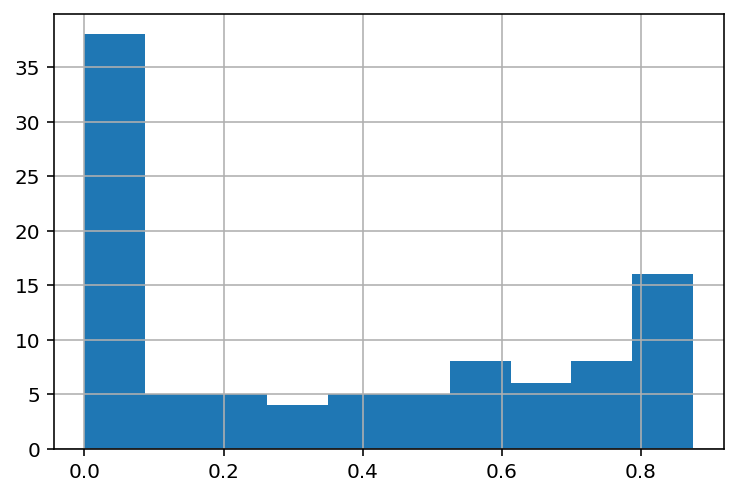

In [170]:
%%time
runs = 100
reps = 100
p_l = sample_params_calc_likelihoods(f_with_aneuploidy, reps=reps, runs=runs)
norm = p_l
pd.Series([p[1] for p in p_l]).hist()

CPU times: user 5min 51s, sys: 2.46 s, total: 5min 53s
Wall time: 6min 8s


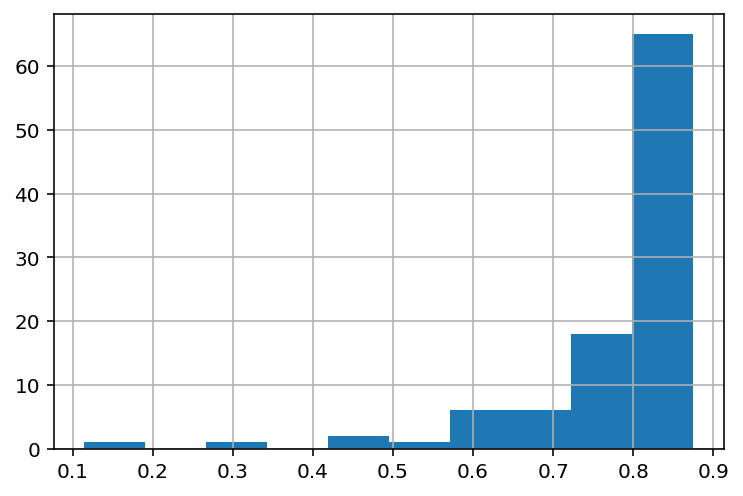

In [171]:
%%time
runs = 100
reps = 100
p_l = sample_params_calc_likelihoods(f_fixedm5, reps=reps, runs=runs, mr=1e-5)
m5 = p_l
pd.Series([p[1] for p in p_l]).hist()

CPU times: user 5min 36s, sys: 2.72 s, total: 5min 38s
Wall time: 5min 49s


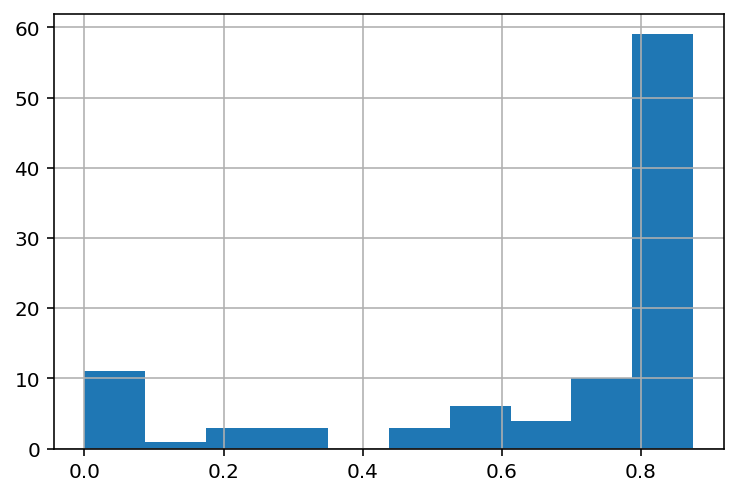

In [172]:
%%time
runs = 100
reps = 100
p_l = sample_params_calc_likelihoods(f_fixedm6, reps=reps, runs=runs, mr=1e-6)
m6 = p_l
pd.Series([p[1] for p in p_l]).hist()

CPU times: user 5min 2s, sys: 2.07 s, total: 5min 4s
Wall time: 5min 11s


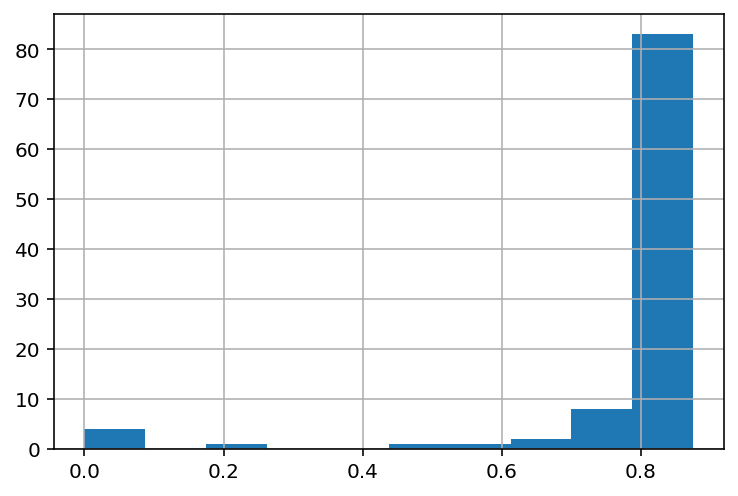

In [401]:
%%time
runs = 100
reps = 100
p_l = sample_params_calc_likelihoods(f_fixedm7, reps=reps, runs=runs, mr=1e-7)
m7 = p_l
pd.Series([p[1] for p in p_l]).hist()

CPU times: user 4min 55s, sys: 1.7 s, total: 4min 57s
Wall time: 5min 2s


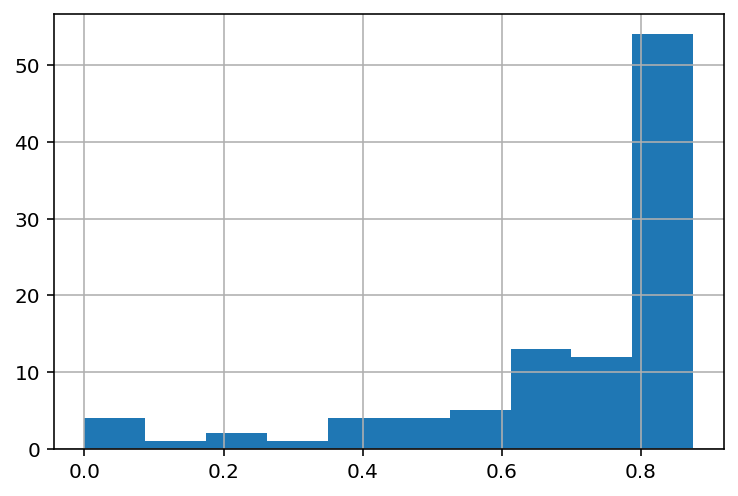

In [404]:
%%time
runs = 100
reps = 100
p_l = sample_params_calc_likelihoods(f_fixedm8, reps=reps, runs=runs, mr=3*10**-6)
m8 = p_l
pd.Series([p[1] for p in p_l]).hist()

CPU times: user 7min 43s, sys: 3.29 s, total: 7min 46s
Wall time: 8min 3s


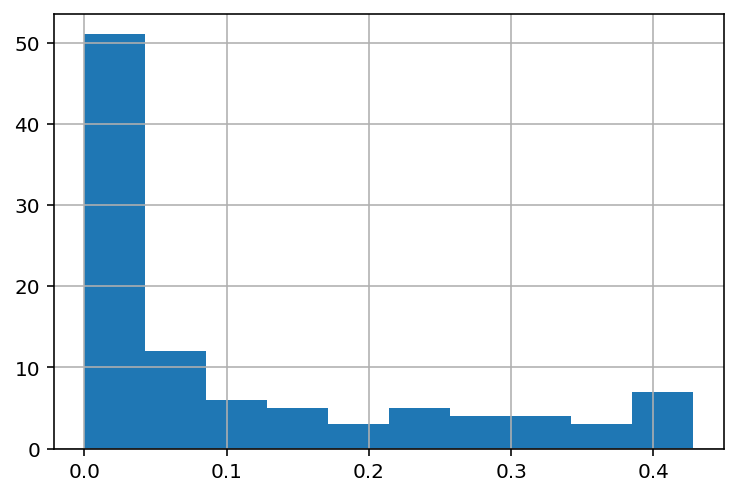

In [425]:
%%time
runs = 100
reps = 100
p_l = sample_params_calc_likelihoods(f_prior4, reps=reps, runs=runs)
prior4 = p_l
pd.Series([p[1] for p in p_l]).hist()

CPU times: user 7min 5s, sys: 4.07 s, total: 7min 9s
Wall time: 7min 38s


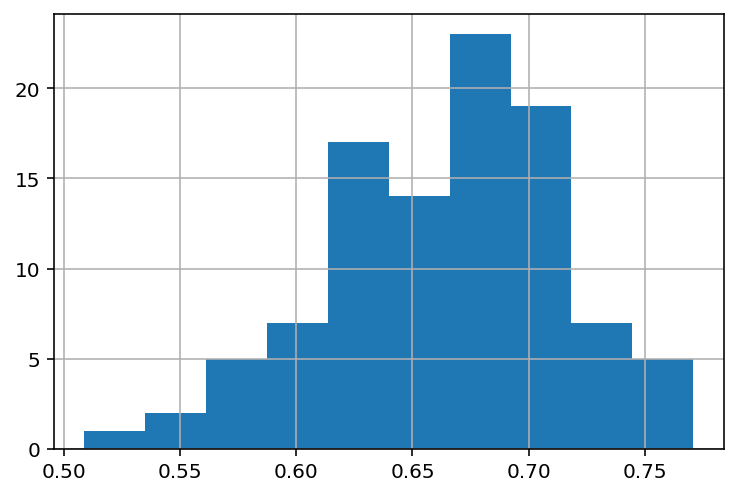

In [174]:
%%time
runs = 100
reps = 100
p_l = sample_params_calc_likelihoods(f_no_aneuploidy, reps=reps, runs=runs)
no_an = p_l
pd.Series([p[1] for p in p_l]).hist()

## WAIC

In [403]:
from scipy.special import logsumexp

def WAIC_with_weights(likelihoods, rounding=None, weights = None):
    if not weights:
        weights = [1/len(likelihoods)]*len(likelihoods)
    loglik_E = np.log(sum(a*b for a,b in zip(weights,likelihoods)))
    #for p2
    E_loglik = sum(a*np.log(b) for a,b in zip(weights,likelihoods))
    p2 = sum((w*(l-E_loglik)**2 for w,l in zip(weights,np.log(likelihoods))))
    ans =  -2*loglik_E + 2*p2
    if rounding:
        ans = round(ans, rounding)
    return ans

def WAIC_for_weighted_samples(f, tminus=0):
    # TODO maybe it should be calculated using kde samples...
    history = pyabc.History("sqlite:///{0}/{1}/{1}.db".format(path,f))
    hist_stats = history.get_weighted_sum_stats(t=history.max_t-tminus)
    likelihoods = [a['res']-1 for a in hist_stats[1]]
    likelihoods = -np.array(likelihoods) + 0.000001
    weights = hist_stats[0]
    return WAIC_with_weights(likelihoods, weights)

# just another implementation for sanity check
def WAIC_version2(logliks, ddof=0): 
    l_logliks = [np.log(l) for l in logliks]
    l_logliks = np.array(l_logliks)
    S = len(l_logliks)
    llpd = -np.log(S) + logsumexp(l_logliks)
#     p1 = 2*(-np.log(S) + logsumexp(l_logliks) - l_logliks.mean())
    p2 = np.var(l_logliks, ddof=ddof)
    return -2*(llpd + -p2)

def getl(arr, add=0):
    return [a[1]+add for a in arr] 

In [252]:
print('WAICs')
print('no aneuploidy', WAIC_with_weights(getl(no_an,1e-6)))
print('norm',WAIC_with_weights(getl(norm,1e-6)))
print('m5',WAIC_with_weights(getl(m5,1e-6)))
print('m6',WAIC_with_weights(getl(m6,1e-6)))
print('m7',WAIC_with_weights(getl(m7,1e-6))) # IT was bug here

WAICs
no aneuploidy 0.8320648495412682
norm 67.85814357776349
m5 0.6011016147521643
m6 33.89371349032772
m7 29.580856529687523


In [426]:
print('WAICs')
print('no aneuploidy', WAIC_with_weights(getl(no_an,1e-6)))
print('norm',WAIC_with_weights(getl(norm,1e-6)))
print('m5',WAIC_with_weights(getl(m5,1e-6)))
print('m6',WAIC_with_weights(getl(m6,1e-6)))
print('m7',WAIC_with_weights(getl(m7,1e-6)))
print('m8',WAIC_with_weights(getl(m8,1e-6)))
print('prior4',WAIC_with_weights(getl(prior4,1e-6)))

WAICs
no aneuploidy 0.8320648495412682
norm 67.85814357776349
m5 0.6011016147521643
m6 33.89371349032772
m7 8.161626928596823
m8 10.028007779687995
prior4 71.91148651904898


In [343]:
k10 = '2021-12-20-an200-k10'
k5 = '2021-12-20-an200-k5' 
k2 = '2021-12-20-an200-k2' 
k1 = '2021-12-29-an200-k1'
k103125 = '2021-12-16-an200-1000reps22'
k100 = '2022-01-12-tau100-r1k'
allf = [k1, k103125, k2, k5, k10, k100]

In [264]:
%%time
runs = 100
reps = 100
tau_likelihoods = [sample_params_calc_likelihoods(f, reps=reps, runs=runs) for f in allf]

CPU times: user 29min 16s, sys: 11.5 s, total: 29min 27s
Wall time: 31min 2s


In [367]:
results = []
results.append(dict(Model='Without aneuploidy', WAIC=WAIC_with_weights(getl(no_an,1e-6),2)))
# results.append(dict(Model='(2) Free mutation rate, $\mu$', WAIC=WAIC_with_weights(getl(norm,1e-6),2)))
# results.append(dict(Model='(2) Fixed mutation rate, $\mu=10^{{-{5}}}$', WAIC='$\\textbf{' + str(WAIC_with_weights(getl(m5,1e-6),2))+'}$'))
results.append(dict(Model='Fixed mutation rate, $\mu=10^{{-{5}}}$', WAIC=WAIC_with_weights(getl(m5,1e-6),2)))
results.append(dict(Model='Fixed mutation rate, $\mu=10^{{-{6}}}$', WAIC=WAIC_with_weights(getl(m6,1e-6),2)))
results.append(dict(Model='Fixed mutation rate, $\mu=10^{{-{7}}}$', WAIC=WAIC_with_weights(getl(m7,1e-6),2)))
labels = ['Free mutation rate, $\\tau=1$','Free mutation rate, $\\tau=33/32$',
          'Free mutation rate, $\\tau=2$','Free mutation rate, $\\tau=5$','Free mutation rate, $\\tau=10$',
          'Free mutation rate, $\\tau=100$']
for f,l,like in zip(allf, labels, tau_likelihoods):
    results.append(dict(Model=l, WAIC=WAIC_with_weights(getl(like,1e-6),2)))
results

[{'Model': 'Without aneuploidy', 'WAIC': 0.83},
 {'Model': 'Fixed mutation rate, $\\mu=10^{{-{5}}}$', 'WAIC': 0.6},
 {'Model': 'Fixed mutation rate, $\\mu=10^{{-{6}}}$', 'WAIC': 33.89},
 {'Model': 'Fixed mutation rate, $\\mu=10^{{-{7}}}$', 'WAIC': 29.58},
 {'Model': 'Free mutation rate, $\\tau=1$', 'WAIC': 78.52},
 {'Model': 'Free mutation rate, $\\tau=33/32$', 'WAIC': 65.92},
 {'Model': 'Free mutation rate, $\\tau=2$', 'WAIC': 85.32},
 {'Model': 'Free mutation rate, $\\tau=5$', 'WAIC': 71.89},
 {'Model': 'Free mutation rate, $\\tau=10$', 'WAIC': 77.38},
 {'Model': 'Free mutation rate, $\\tau=100$', 'WAIC': 57.67}]

In [393]:
df = pd.DataFrame(results)
df.index = np.arange(1, len(df)+1)
df.index.rename('id', inplace=True)
df = df.reset_index().rename({'index':'index1'}, axis = 'columns')
df.to_csv(f'{output_path}/Table_WAIC.csv', index=False, float_format="%.2f", sep=';')
df

,id,Model,WAIC
0,1,Without aneuploidy,0.83
1,2,"Fixed mutation rate, $\mu=10^{{-{5}}}$",0.60
2,3,"Fixed mutation rate, $\mu=10^{{-{6}}}$",33.89
3,4,"Fixed mutation rate, $\mu=10^{{-{7}}}$",29.58
4,5,"Free mutation rate, $\tau=1$",78.52
5,6,"Free mutation rate, $\tau=33/32$",65.92
6,7,"Free mutation rate, $\tau=2$",85.32
7,8,"Free mutation rate, $\tau=5$",71.89
8,9,"Free mutation rate, $\tau=10$",77.38
9,10,"Free mutation rate, $\tau=100$",57.67


,#,Model,WAIC
0,1,Without aneuploidy,0.83
1,2,"Fixed mutation rate, $\mu=10^{{-{5}}}$",0.60
2,3,"Fixed mutation rate, $\mu=10^{{-{6}}}$",33.89
3,4,"Fixed mutation rate, $\mu=10^{{-{7}}}$",29.58
4,5,"Free mutation rate, $\tau=1$",78.52
5,6,"Free mutation rate, $\tau=33/32$",65.92
6,7,"Free mutation rate, $\tau=2$",85.32
7,8,"Free mutation rate, $\tau=5$",71.89
8,9,"Free mutation rate, $\tau=10$",77.38
9,10,"Free mutation rate, $\tau=100$",57.67
